<a href="https://colab.research.google.com/github/gsamp/MLMs/blob/main/Language_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
# download the txt file
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-02-18 23:06:57--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-02-18 23:06:57 (30.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read file to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

### Encoding / Decoding

In [ ]:
# get all of the unique characters that occur in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# string to integer mapping
stoi = { ch : i for i, ch in enumerate(chars) }
# integer to string mapping
itos = { i : ch for i, ch in enumerate(chars) }

# encoder: take a string, return list of numbers
encode = lambda string: [stoi[ch] for ch in string]
# decoder: take a list of numbers, return a string
decode = lambda lst: ''.join([itos[i] for i in lst])

print(encode("hello world"))
print(decode(encode("hello world")))

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]
hello world


In [ ]:
# encode the entire text dataset and store it into a torch.Tensor
import torch

data = torch.tensor(encode(text), dtype=torch.long)

print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


### Train / Val splits

In [ ]:
n = int(0.90*len(text))

train_data = data[:n]
val_data = data[n:]

### Context (block_size) in Language Modeling

In [ ]:
block_size = 8

# The context size is 8, but we need to reference 9 elements because of the attention mechanism
# in which the 8th element will influence the next one
first_block = train_data[:block_size + 1]
first_block

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
x = first_block
y = train_data[1:block_size + 1]

for t in range(block_size):
    context = x[:t + 1] # the first value of t is 0. any_list[:0] is just the empty set
    target = y[t]      # y is already offsetted by 1
    print(f"context: {context}, target: {target}")

context: tensor([18]), target: 47
context: tensor([18, 47]), target: 56
context: tensor([18, 47, 56]), target: 57
context: tensor([18, 47, 56, 57]), target: 58
context: tensor([18, 47, 56, 57, 58]), target: 1
context: tensor([18, 47, 56, 57, 58,  1]), target: 15
context: tensor([18, 47, 56, 57, 58,  1, 15]), target: 47
context: tensor([18, 47, 56, 57, 58,  1, 15, 47]), target: 58


In [ ]:
# The input to the transformer is a tensor of shape (batch_size, context_size)
# We will now build a random input tensor
torch.manual_seed(1337)

batch_size = 4 # The number of inputs we'll process in parallel, the number of rows
block_size = 8 # The maximum size of the context

def get_batch(split : str):
    data = train_data if split == 'train' else val_data
    idx = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in idx])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in idx])
    return x, y

# Randomly generated examples input and target
xb, yb = get_batch('train')
print(xb.shape)
print(xb)

print(yb.shape)
print(yb)

torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


### Attention Mechanism

In [ ]:
# Mechanism
wei = torch.tril(torch.ones((3, 3)))
wei = wei / torch.sum(wei, 1, keepdim=True)
print(wei)

query = torch.randint(0, 10, (3, 2)).float()
print(query)

result = wei @ query
print(result)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[5., 3.],
        [5., 0.],
        [4., 0.]])
tensor([[5.0000, 3.0000],
        [5.0000, 1.5000],
        [4.6667, 1.0000]])


In [ ]:
# Toy example

torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch size, block size, channels
x = torch.randn((B, T, C))
x.shape

torch.Size([4, 8, 2])

In [ ]:
# we want: x[b, t] = mean_{i <= t} x[b, i]

# Option 1: For loop

xbow = torch.zeros((B, T, C))
for b in range(B):      # for each batch
    for t in range(T):  # for each timestep
        xprev = x[b, :t + 1]              # everything up to and including the th token (t,C)
        xbow[b, t] = torch.mean(xprev, 0) # average over the time (batches are independent)

In [ ]:
# Option 2: Matrix multiply for weighted aggregation

wei = torch.tril(torch.ones((T, T)))
wei = wei / wei.sum(1, keepdim=True) # B, T, C

xbow2 = wei @ x # (T, T) @ (B, T, C) -> (B, T, C) --> pytorch adds the B dimension

In [ ]:
# Option 3: Use softmax
wei = torch.tril(torch.ones((T, T)))
wei = wei.masked_fill(wei == 0, float('-inf'))
wei = F.softmax(wei, dim = -1) # this dimension does not matter

xbow3 = wei @ x

### Single-headed Self-attention block

In [ ]:
# initialize a random tensor x of shape 4, 8, 32
B, T, C = 4, 8, 32
x = torch.rand((B, T, C))

# set key, query, value to be linear layer of head_size = 16 (bias = False)
head_size = 16
key = nn.Linear(C, head_size, bias = False)
query = nn.Linear(C, head_size, bias = False)
value = nn.Linear(C, head_size, bias = False)

k = key(x) # (B, T, head_size)
q = query(x) # (B, T, head_size)

# study shapes
# print(q.shape)                   # (B, T, head)
# print(q.transpose(-2, -1).shape) # (B, head, T)
# print(q.transpose(-1, -3).shape) # (head, T, B)
# print(q.transpose(-2, -3).shape) # (T, B, head)

# Encoding attention:
wei = q @ k.transpose(-1, -2) # (B, T, head_size) @ (B, head_size, T) --> (B, T, T)

# Decoding attention:
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim = -1) # this dimension does not really matter

# Scaled attention:
# divides wei by 1/sqrt(head_size)
wei = q @ k.transpose(-1, -2) * head_size ** -0.5

v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

#### Attention notes:

- Attention is a communication mechanism. You can see it as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

- There is no notion of space in attention, it just acts over a set of vectors.

- Each example across the batch dimension is processed independently and don't interact with one another.

- An Encoder attention block does not apply the lower triangular mask, allowing all tokens to communicate.

- A Decoder attention block applies triangular masking. This allows it to be used in autoregressive settings (using the past to predict the future), such as language modeling.

- A Scaled attention block divides the affinities (`wei`) by sqrt(head_size). This makes it so that, if Q, K are unit variance, then `wei` will also be unit variance, and Softmax will stay diffuse and not saturate too much.

- Self attention means that they keys and values are produced from the same source as the queries.

- Cross attention means that the queries are still produced from x, but the keys and values come from some other source (for example, an encoder module)

In [ ]:
n_embed = None
dropout = 0.2 # dropout rate

In [ ]:
""" one head of scaled dot-product self-attention """
class Head(nn.Module):
    def _init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)

        # If you have parameters in your model, which should be saved and restored in the state_dict,
        # but not trained by the optimizer, you should register them as buffers.
        self.register_buffer('tril', torch.tril(torch.ones((block_size, block_size))))

        # optionally
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)

        # affinities
        wei = q @ k.transpose(-2, -1) # * head_size ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim = -1) # this dimenision does not really matter

        # perform weigthed aggregation of the values
        v = self.value(x)
        out = wei @ v

        return out

In [ ]:
""" multiple heads of self-attention in parallel, concatenating their results"""
class MultiheadAttention(nn.Module):
    def _init__(self, head_size, num_heads):
        super().__init__()
        # nn.ModuleList will run things in parallel
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # this is so that the network learns during training how much of the residual pathway it wants to activate
        self.residual_projection = nn.Linear(n_embed, n_embed)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, C) we concatenate over the channel dimension
        out = self.residual_projection(out)
        return out

In [ ]:
""" a simple linear layer followed by a non-linearity """
class FeedForward(nn.Module):
    def _init__(self, n_embed):
        super().__init__()
        # nn.Sequential will run things in sequence
        self.network = nn.Sequential(
            # in the Attention is all you need paper, the output dimension of the linear layer
            # is 4 * input dimension
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),

            # residual projection, so that the network learns how much of the residual pathway it wants to activate
            nn.Linear(4 * n_embed, n_embed),

            # optionally
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
""" Transformer block: communication followed by computation """
class TransformerBlock(nn.Module):
    def _init__(self, n_embed, num_heads):
        super().__init__()
        head_size = n_embed // num_heads
        # communication
        self.multi_head_attention = MultiheadAttention(head_size, num_heads)
        # computation
        self.ffwd = FeedForward(n_embed)

        # layer normalization
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)


    def forward(self, x):
        # without residual connections
        # x = self.multi_head_attention(x)
        # x = self.ffwd(x)

        # with residual connections
        x = x + self.multi_head_attention(x)
        x = x + self.ffwd(x)

        # with residual connections and layer normalization
        x = x + self.multi_head_attention(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
""" Positional Encoding: attention is position invariant """

class PositionalEncoding(nn.Module):
    def __init__(self, sentence_length, dimension_size):
        super().__init__()

        # create positional encoding tensor to store all encodings
        pe = torch.zeros(sentence_length, dimension_size, dtype=torch.float)

        # will create a column vector with the indexes from 0 to sentence_length
        # unsqueeze will add one dimension along the specified dimension
        position = torch.arange(sentence_length).unsqueeze(1)

        # notice how this term will have half the length of the position term
        div_term = torch.exp(
            torch.arange(0, dimension_size, 2) * (-math.log(10000) / dimension_size)
        )

        # populate positional encoding
        pe[:, 0::2] == torch.sin(position * div_term)
        pe[:, 1::2] == torch.cos(position * div_term)

        # register as a buffer so autograd doesn't modify
        self.register_buffer('pe', pe.unsqueeze(0), persistent=False)

    def forward(self, x):
        # return the pre-calculated positional encodings
        # up to sequence length (S). output shape (1, S, C)
        return self.pe[:, :x.shape[1], :]

In [ ]:
# https://benjaminwarner.dev/2023/07/28/rest-of-the-transformer

class BERT(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, x):
        pass

### Simple Bigram Language Model

In [ ]:
# In this formulation, each token directly reads off
# the logits for the next token from a lookup table
# that stores the counts of the tokens in the datasets
# and use that to estimate the probability that a token follows
# its precedent

# PyTorch implements its embeddings as a lookup table
# of shape input_dimension, embedding_dimension.
# Each row contains an embedding vector for a specific input token.
# The output vector of the embedding layer is the token vector
# which is passed through the model’s Transformer layers.

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)
        B, T, C = logits.shape

        if targets is None:
            loss = None
        else:
            logits = logits.view(B*T, C)
            targets = targets.view(B*T) # single row
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
model = BigramLanguageModel(vocab_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
num_epochs = 10000

_, loss = model(xb, yb)
print("Loss at the beginning: ", loss.item())
print("Example generation at the beginning: ", decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))
print("-----")

def train(model, optimizer):
    # print('Before')
    # print(f'Train loss (over entire dataset): ')
    # print(f'Val loss: ')

    for epoch_index in range(num_epochs):

        # sample a batch of data
        xb, yb = get_batch('train')

        logits, loss = model(xb, yb)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    # print('After')
    # print(f'Train loss (over entire dataset): ')
    # print(f'Val loss: ')
    print("Loss at the end: ", loss.item())

train(model, optimizer)

print("Example generation at the end: ", decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

Loss at the beginning:  5.123445987701416
Example generation at the beginning:  
,HA.iSXMj :YGGjfhmUZ?LSvvAIXbUFBr3-uy;$gB&KW!
Ok-UkOg&gHSMZWKKU3D$bCTDTOHKjR;JzCk-M-Jf;3sUs:Yo?uLUf;
-----
Loss at the end:  2.4729809761047363
Example generation at the end:  
TYos, NROLIEO teimI:xeWWillther'st, m ousid lcorar met'er m hte.
HSolFofsesok--fr hace sphemowha s.?


#### Word2Vec

- Word2vec: Word2vec is a technique in natural language processing (NLP) for obtaining vector representations of words.

These vectors capture information about the meaning of the word and their usage in context.

The word2vec algorithm estimates these representations by modeling text in a large corpus.

Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence.

These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words.

Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space.

- Continuous Bag of Words: use surrounding words to predict the word in the middle

- Skip Gram: uses the word in the middle to predict the surrounding words

#### TODO: Bigram Model with Attention / Transformer Block

Kaparthy: [(link)](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=Hs4kI8YdEkQj)

### Layer and Batch Normalization

In [ ]:
# We want our pre-activation values to be unit gaussian,
# so we normalize them to be unit gaussian

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps            # to avoid division by zero
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.zeros(dim)    # batch norm "W"
        self.beta = torch.ones(dim)      # batch norm "b"

        # buffers (trained with a running momentum update)
        self.register_buffer('running_mean', torch.zeros(dim))
        self.register_buffer('running_var', torch.ones(dim))

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        x_preactivation = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize column to unit variance
        out = self.gamma * x_preactivation + self.beta

        # compute running mean and var for inference time
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_mean + self.momentum * xvar

        return out

    def parameters(self):
        return [self.gamma, self.beta]

In [ ]:
class LayerNorm1d:
    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True)   # batch variance
        x_preactivation = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize row to unit variance
        self.out = self.gamma * x_preactivation + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [ ]:
torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)

print("x shape: ", x.shape)
print("mean, std across batch for 1 feature: ", x[:,0].mean(), x[:,0].std()) # mean,std of one feature across all batch inputs
print("mean, std across row for 1 feature: ", x[0,:].mean(), x[0,:].std()) # mean,std of a single input from the batch, of its features

x shape:  torch.Size([32, 100])
mean, std across batch for 1 feature:  tensor(0.1469) tensor(0.8803)
mean, std across row for 1 feature:  tensor(-9.5367e-09) tensor(1.0000)


### Regularization




*   Classification: At initialization, we'd like that the probability over the set of possible choices is uniform. That'd imply we have no information about the problem (random baseline).

- L1 regularization forces some weights to go to zero (if the penalty is high enough) creating a sparse model so implicitly it is doing some pruning as opposed to L2 regularization.

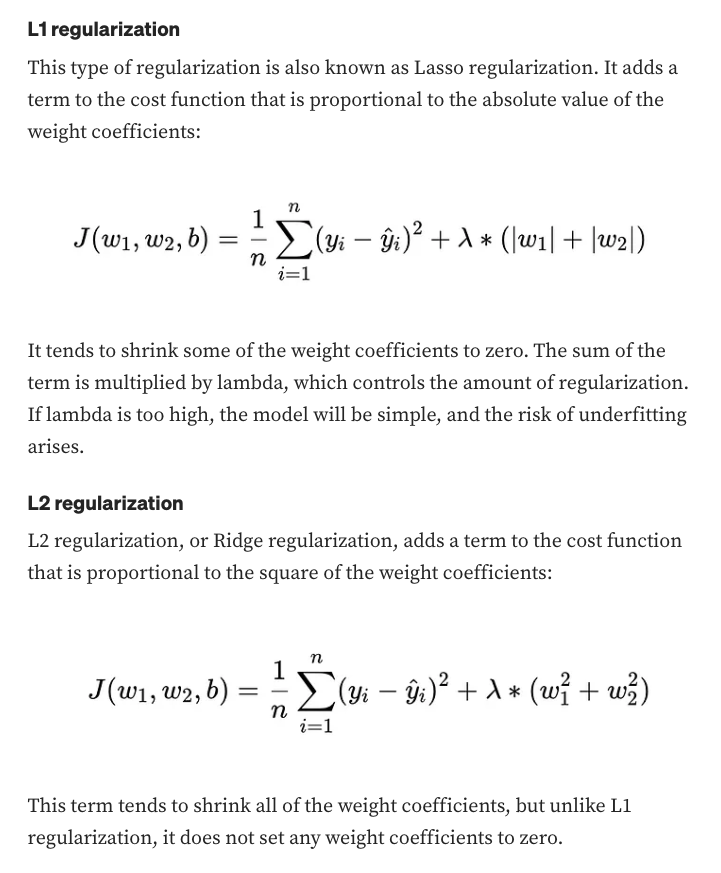

### Bias-Variance Tradeoff

Come from the decomposition of mean squared error.

- Bias: it's the square of the distance between your average prediction and the true labels

- Variance: it's the expectation of the variance of your predictions

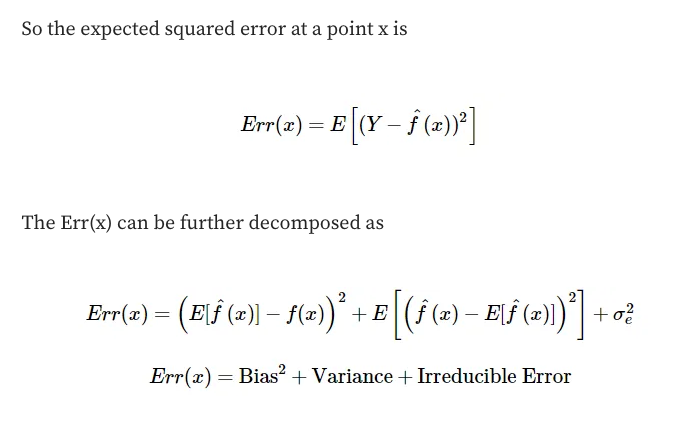

- The tradeoff comes from the realization that you cannot reduce one without increasing the other.

- Additionally all models have some irreducible error which cannot be reduced (due to the noise in the dataset).

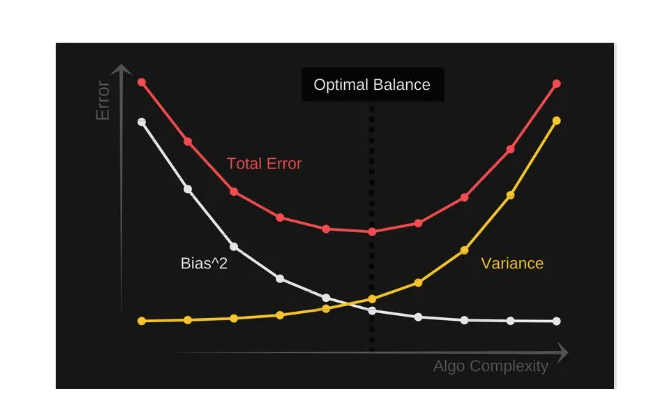

### Optimization & Gradient Descent

A typical optimization problem includes an objective function that is to be minimized or maximized with the given constraints.

Optimization algorithms in machine learning (especially in neural networks) aim at minimizing an objective function (generally called loss or cost function), which is intuitively the difference between the predicted data and the expected values.

Gradient descent is an optimization algorithm that uses the gradient of the objective function to navigate the search space.

Stochastic gradient descent (SGD), Adam, and RMSprop are all examples of first-order optimization algorithms, as they use the first derivatives of the function they are trying to minimize.


In [ ]:
### Gradient descent

learning_rate = 1

## assume w and b are coefficients of x
weight = torch.ones((3, 2))
bias = torch.ones((3, 2))

dw = torch.ones((3, 2)) * 0.2
db = torch.ones((3, 2)) * 0.2

def gradient_descent(learning_rate, dw, db, w, b):
    w -= learning_rate * dw
    b -= learning_rate * db
    return w, b

print("Weight and bias: ", weight, bias, "\n")
print("Derivarives: ", dw, db, "\n")

print("Weight and bias (after gradient descent): ", gradient_descent(learning_rate, dw, db, weight, bias), "\n")

Weight and bias:  tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]) tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]) 

Derivarives:  tensor([[0.2000, 0.2000],
        [0.2000, 0.2000],
        [0.2000, 0.2000]]) tensor([[0.2000, 0.2000],
        [0.2000, 0.2000],
        [0.2000, 0.2000]]) 

Weight and bias (after gradient descent):  (tensor([[0.8000, 0.8000],
        [0.8000, 0.8000],
        [0.8000, 0.8000]]), tensor([[0.8000, 0.8000],
        [0.8000, 0.8000],
        [0.8000, 0.8000]])) 



#### RMS Prop

Gradients of very complex functions like neural networks have a tendency to either vanish or explode as the data propagates through the function (refer to vanishing gradients problem). **Rmsprop was developed as a stochastic technique for mini-batch learning.**

RMSprop deals with the above issue by **using a moving average of squared gradients to normalize the gradient**. This normalization balances the step size (momentum), decreasing the step for large gradients to avoid exploding and increasing the step for small gradients to avoid vanishing.

In [ ]:
### RMS Prop

# Computes the moving average of the derivatives of the parameters that are being optimized

def RMSprop(momentum, dw, db, w, b, running_dw, running_db, eps):
    running_dw = momentum * running_dw + (1 - momentum) * dw**2
    running_db = momentum * running_db + (1 - momentum) * db**2

    w -= dw / (torch.sqrt(running_dw)+ eps)
    b -= db / (torch.sqrt(running_db)+ eps)
    return w, b

In [ ]:
learning_rate = 1

## assume w and b are coefficients of x
w = torch.ones((3, 2))
b = torch.ones((3, 2))

dw = torch.ones((3, 2)) * 0.2
db = torch.ones((3, 2)) * 0.2

print("Weight and bias: ", w, b, "\n")
print("Derivarives: ", dw, db, "\n")

print("Weight and bias (after gradient descent): ", RMSprop(0.99, dw, db, w, b, 1.0, 1.0, 0.005), "\n")

Weight and bias:  tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]) tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]) 

Derivarives:  tensor([[0.2000, 0.2000],
        [0.2000, 0.2000],
        [0.2000, 0.2000]]) tensor([[0.2000, 0.2000],
        [0.2000, 0.2000],
        [0.2000, 0.2000]]) 

Weight and bias (after gradient descent):  (tensor([[0.8000, 0.8000],
        [0.8000, 0.8000],
        [0.8000, 0.8000]]), tensor([[0.8000, 0.8000],
        [0.8000, 0.8000],
        [0.8000, 0.8000]])) 



#### Adam Optimizer

Adam is a first-order-gradient-based algorithm of stochastic objective functions, based on adaptive estimates of lower-order moments.

The first moment normalized by the second moment gives the direction of the update.

In [ ]:
import numpy

def printDistances(distances, token1Length, token2Length):
    for t1 in range(token1Length + 1):
        for t2 in range(token2Length + 1):
            print(int(distances[t1][t2]), end=" ")
        print()

def levenshteinDistanceDP(token1, token2):
    distances = numpy.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2

    a = 0
    b = 0
    c = 0

    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]

                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    printDistances(distances, len(token1), len(token2))
    return distances[len(token1)][len(token2)]

In [ ]:
levenshteinDistanceDP("banaba", "banana")

0 1 2 3 4 5 6 
1 0 1 2 3 4 5 
2 1 0 1 2 3 4 
3 2 1 0 1 2 3 
4 3 2 1 0 1 2 
5 4 3 2 1 1 2 
6 5 4 3 2 2 1 


1.0

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        out = self.mlp(x)
        return out
